# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

# Project 1 Isolated digit recognition in noisy environments

- Assigned: 2023/04/21
- Due: 2023/05/04
- Required dataset: 
    1. [training data](lab05.pdf)
    1. [validation data](lab05.md)
    1. [test data](lab05.md)

########################################################################
## 본 프로젝트의 모든 코드는 EPD,  Wiener filtering부분을 제외하고는
## https://github.com/gjang7/ssp2023/blob/main/proj1/proj1_nidr.ipynb
## 를 변형하여 수행되었습니다.

## 전인구 수정
########################################################################

----
# import packages, define analysis parameters and draw parameters, audio file preparation, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

오디오 파일들의 경로 정의

In [2]:
# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [3]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [4]:
# parameters for signal analysis
Fs = 16000  #native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [5]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### wav파일 처리를 위해
### 아래 링크들에서 정의된 함수를 그대로 사용했습니다.
#### gjdrawspectrogram3 :  https://github.com/gjang7/ssp2023/tree/main/proj1/gjdrawspectrogram3.py
#### gjwavfile : https://github.com/gjang7/ssp2023/tree/main/proj1/gjwavfile.py



In [6]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# save audio in wav format
import gjwavfile as wav

---
### load speech and noise

오디오 파일이 16 kHz, mono 인지 확인 

In [7]:
x = np.zeros(10)
print(len(x), x.ndim)
x = np.zeros((10,2))
print(len(x), x.ndim)

10 1
10 2


In [8]:
# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [9]:
def check_audio_file(file, defFs, checkMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    if defFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(defFs, Fs, file))
        return False
    elif checkMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            return False
        return True
    elif size(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
    else:
        return True

def convert_audio_file(file, forceFs, forceMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    changed = False
    if forceFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(forceFs, Fs, file))
        signal, Fs = librosa.load(file, sr=forceFs, mono=False)
        changed = True
    elif forceMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            signal, Fs = librosa.load(file, sr=forceFs, mono=True)
            changed = True
    elif size(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
        return False
    if changed == True:
        wav.writewav(file, Fs, signal, maxval=1.0)
        print('updating', file)
    return changed

def audio_statistics(file): # 데이터의 통계적인 특성을 확인하는 함수
    signal, Fs = librosa.load(file, sr=None, mono=False)
    Time_len=len(signal)/Fs
    mean_t=np.mean(signal)
    Var_t=np.mean((signal-mean_t)**2)
    max_t=np.max(np.abs(signal))
    return Time_len,mean_t,Var_t, max_t

Dandyst: false 0 / 100

son: false 0 / 100

YouYeNa: false 0 / 100

11jeonghy: false 0 / 100

InkooJeon: false 0 / 100

do: false 0 / 100

chlee: false 0 / 100



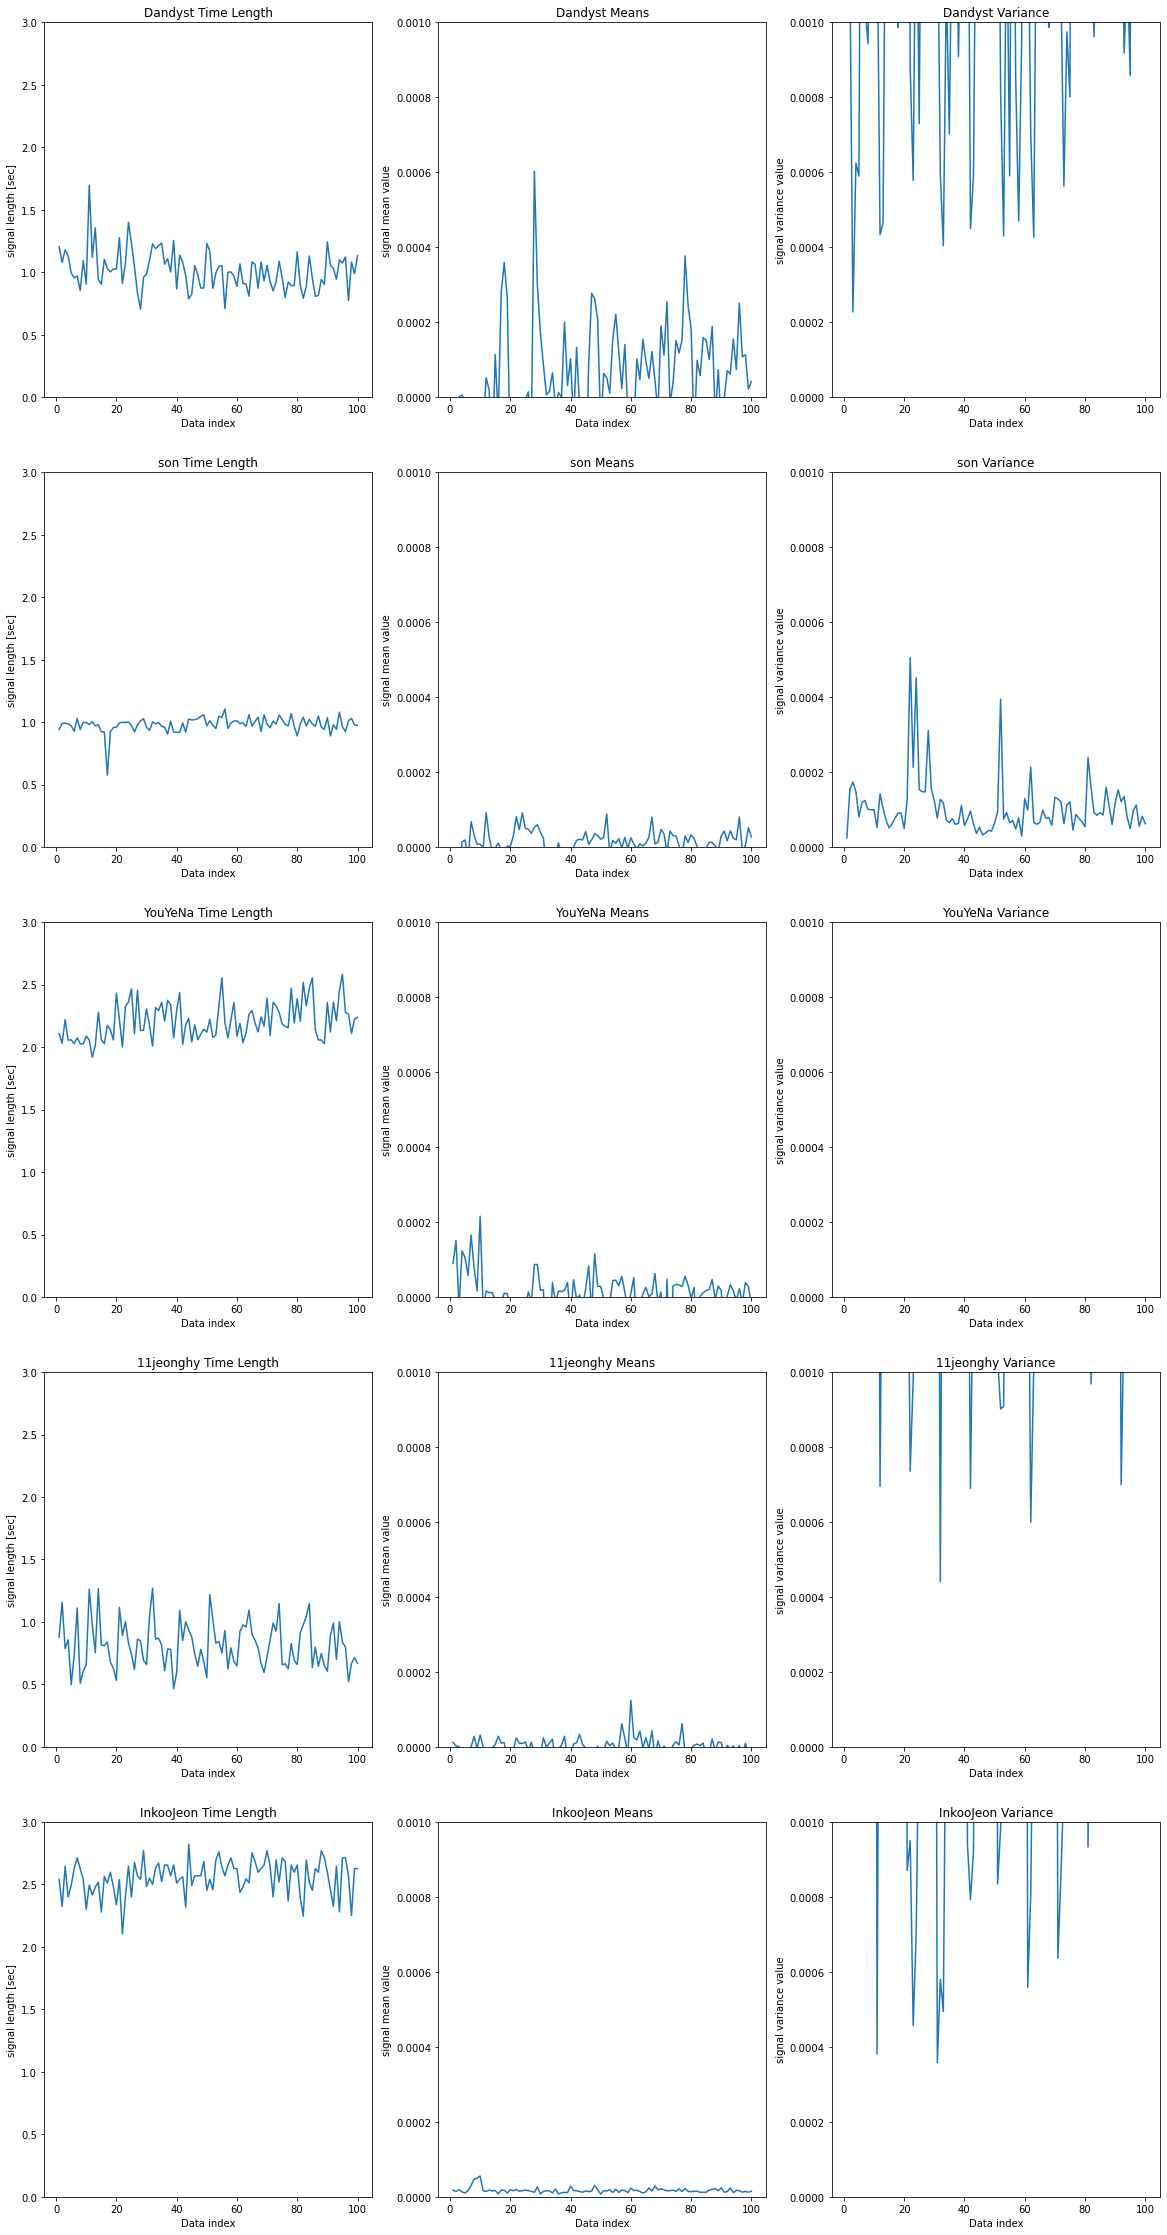

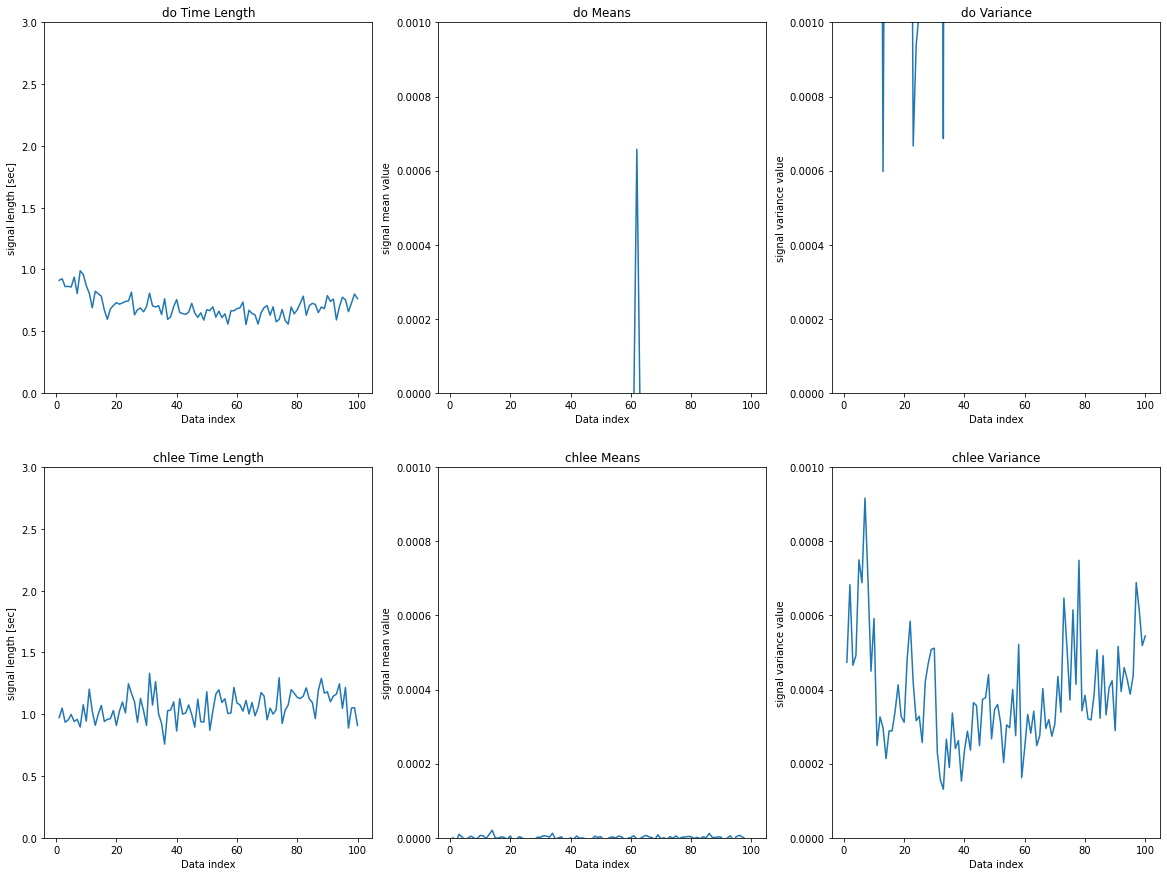

In [10]:
trainroot = 'segmented-train'
'''
labels_all = {'11jeonghy', 
                'Dandyst', 
                'InkooJeon',
                'YouYeNa',
                'chlee',
                'deokkyukwon',
                'do',
                'kyeong',
                'ohjihyeon',
                'son',
               }
'''
labels_train = {'11jeonghy', 
                'Dandyst', 
                'InkooJeon',
                'YouYeNa',
#                 'deokkyukwon',
#                 'ohjihyeon',
                'son',
               }

valroot = 'segmented-val'
valorg = addpath(valroot, 'org')
labels_val = {
                'chlee',
                'do',
#                 'kyeong', # 라벨링이 하나씩 밀려있었다.
               }

# check
Fs = 16000

Time_len_train=[]
mean_train=[]
Var_train=[]
train_label_array=[x for x in labels_train]

Data_path_list=[]

for subname in labels_train:
    num_files = 0
    num_false_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            file = addpath(trainroot, addpath(subname, basename))
            num_files += 1
            Data_path_list.append(file)
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
            [L_tmp,m_tmp,V_tmp,max_tmp]=audio_statistics(file)
            Time_len_train.append(L_tmp)
            mean_train.append(m_tmp)
            Var_train.append(V_tmp)
    print('%s: false %d / %d\n'%(subname, num_false_files, num_files))

plt.figure(figsize=[20,40])
for plot_idx in range(len(labels_train)): # train dataset의 통계적 특성
    plt.subplot(len(labels_train),3,plot_idx*3+1)
    plt.plot(np.arange(1,101),Time_len_train[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(train_label_array[plot_idx]+' Time Length')
    plt.xlabel("Data index")
    plt.ylabel("signal length [sec]")
    plt.ylim([0, 3])
    
    plt.subplot(len(labels_train),3,plot_idx*3+2)
    plt.plot(np.arange(1,101),mean_train[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(train_label_array[plot_idx]+' Means')
    plt.xlabel("Data index")
    plt.ylabel("signal mean value")
    plt.ylim([0, 0.001])

    plt.subplot(len(labels_train),3,plot_idx*3+3)
    plt.plot(np.arange(1,101),Var_train[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(train_label_array[plot_idx]+' Variance')
    plt.xlabel("Data index")
    plt.ylabel("signal variance value")
    plt.ylim([0, 0.001])
    
    

# check
Fs = 16000

Time_len_val=[]
mean_val=[]
Var_val=[]
max_val=[]
val_label_array=[x for x in labels_val]

for subname in labels_val:
    num_files = 0
    num_false_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            file = addpath(valorg, addpath(subname, basename))
            Data_path_list.append(file)
            num_files += 1
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
            [L_tmp,m_tmp,V_tmp,max_tmp]=audio_statistics(file)
            Time_len_val.append(L_tmp)
            mean_val.append(m_tmp)
            Var_val.append(V_tmp)
            max_val.append(max_tmp)

    print('%s: false %d / %d\n'%(subname, num_false_files, num_files))
    
plt.figure(figsize=[20,15])
for plot_idx in range(len(labels_val)): # validation dataset의 통계적 특성
    plt.subplot(len(labels_val),3,plot_idx*3+1)
    plt.plot(np.arange(1,101),Time_len_val[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(val_label_array[plot_idx]+' Time Length')
    plt.xlabel("Data index")
    plt.ylabel("signal length [sec]")
    plt.ylim([0, 3])
    plt.subplot(len(labels_val),3,plot_idx*3+2)
    plt.plot(np.arange(1,101),mean_val[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(val_label_array[plot_idx]+' Means')
    plt.xlabel("Data index")
    plt.ylabel("signal mean value")
    plt.ylim([0, 0.001])

    plt.subplot(len(labels_val),3,plot_idx*3+3)
    plt.plot(np.arange(1,101),Var_val[(plot_idx)*100:(plot_idx+1)*100])
    plt.title(val_label_array[plot_idx]+' Variance')
    plt.xlabel("Data index")
    plt.ylabel("signal variance value")
    plt.ylim([0, 0.001])


---
### Dataset 의 문제점
#### 앞서 봤듯이, 모든 데이터의 특성 (샘플 하나의 크기, 샘플들의 분산) 의 차이가 크다.
#### 또한, 각 화자의 음성 특성과 무관하게 일반적인 특성을 얻기에는 현재의 모델이 너무 작다. 
#### 그래서, 모델의 크기를 키워주는 방법으로 성능 향상을 하고자 한다.

In [11]:

def make_data_pair(Data_list):
    L_data=len(Data_list)
    Result=[]
    for idx in range(L_data):
        splited=Data_list[idx].split(".")
        label=int(splited[0][-1])
        Result.append((Data_list[idx],label))
    return Result            


Data_list=make_data_pair(Data_path_list)
# 데이터를 섞어도 된다면, np.random.shuffle(Data_list) 를 이용해 더 다양한 화자에 대응할 수 있다. 
# np.random.shuffle(Data_list)
total_N_data=len(Data_list)

ratio_train=len(labels_train)
ratio_val=len(labels_val)

N_train=int(ratio_train/(ratio_train+ratio_val)*total_N_data)
Data_train=Data_list[:N_train]
Data_val=Data_list[N_train:]


print('Shuffled training data')
for dis_idx in range(20):
    print(Data_train[dis_idx])
print('...\n==================================')

print('Shuffled validation data')
for dis_idx in range(20):
    print(Data_val[dis_idx])
    
    

Shuffled training data
('segmented-train/Dandyst/0/kdigits0-0.wav', 0)
('segmented-train/Dandyst/0/kdigits1-0.wav', 0)
('segmented-train/Dandyst/0/kdigits2-0.wav', 0)
('segmented-train/Dandyst/0/kdigits3-0.wav', 0)
('segmented-train/Dandyst/0/kdigits4-0.wav', 0)
('segmented-train/Dandyst/0/kdigits5-0.wav', 0)
('segmented-train/Dandyst/0/kdigits6-0.wav', 0)
('segmented-train/Dandyst/0/kdigits7-0.wav', 0)
('segmented-train/Dandyst/0/kdigits8-0.wav', 0)
('segmented-train/Dandyst/0/kdigits9-0.wav', 0)
('segmented-train/Dandyst/1/kdigits0-1.wav', 1)
('segmented-train/Dandyst/1/kdigits1-1.wav', 1)
('segmented-train/Dandyst/1/kdigits2-1.wav', 1)
('segmented-train/Dandyst/1/kdigits3-1.wav', 1)
('segmented-train/Dandyst/1/kdigits4-1.wav', 1)
('segmented-train/Dandyst/1/kdigits5-1.wav', 1)
('segmented-train/Dandyst/1/kdigits6-1.wav', 1)
('segmented-train/Dandyst/1/kdigits7-1.wav', 1)
('segmented-train/Dandyst/1/kdigits8-1.wav', 1)
('segmented-train/Dandyst/1/kdigits9-1.wav', 1)
...
Shuffled vali

---
### HMM training and test 함수 정의

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#from scikits.talkbox.features import mfcc
#librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)[source]
from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
import numpy as np
import os
import warnings
import scipy.stats as sp
from time import time

warnings.filterwarnings("ignore")

############################################################################################## 
# extract MFCC features
def extmfcc(file):
    samplerate, d = wavfile.read(file)
#     Ld=len(d)
#     if Ld > 2*samplerate: # 샘플의 시간 길이가 2초 이상이면 가운데 1초 정도만 사용한다.
#         d=d[Ld//2-int(samplerate/2):Ld//2+int(samplerate/2)] # 샘플의 시간길이를 비슷하게 만들어주기 위함. 
#     if Ld < samplerate:
#         L_padd=int(samplerate)-Ld
#         mu=np.mean(d)
#         var=np.sqrt(np.mean((d-mu)**2))
#         d=np.concatenate([np.random.randn(L_padd//2)*var/100,d,np.random.randn(L_padd//2)*var/100])
    
    #features.append(mfcc(d, nwin=int(samplerate * 0.03), fs=samplerate, nceps= 6)[0])
    x = np.float32(d)
    hop=samplerate//100
    mc = mfcc(y=x, sr=samplerate, n_mfcc=num_mfcc, hop_length=hop, win_length=hop*2)
    return np.transpose(mc, (1,0))

def initByBakis(inumstates, ibakisLevel):
    startprobPrior = np.zeros(inumstates)
    startprobPrior[0: ibakisLevel - 1] = 1/float((ibakisLevel - 1))
    transmatPrior = getTransmatPrior(inumstates, ibakisLevel)
    return startprobPrior, transmatPrior

def getTransmatPrior(inumstates, ibakisLevel):
    transmatPrior = (1 / float(ibakisLevel)) * np.eye(inumstates)

    for i in range(inumstates - (ibakisLevel - 1)):
        for j in range(ibakisLevel - 1):
            transmatPrior[i, i + j + 1] = 1. / ibakisLevel

    for i in range(inumstates - ibakisLevel + 1, inumstates):
        for j in range(inumstates - i - j):
            transmatPrior[i, i + j] = 1. / (inumstates - i)

    return transmatPrior


############################################################################################## 
# hyperparameters - CHANGE THEM TO IMPROVE PERFORMANCE
# 1. number of MFCC (feature dimension)
# num_mfcc = 6
# num_mfcc = 10
# num_mfcc = 13
num_mfcc = 20
# 2. Parameters needed to train GMMHMM
m_num_of_HMMStates = 4 #3  # number of states
m_num_of_mixtures = 3 #2  # number of mixtures for each hidden state
m_covarianceType = 'diag'  # covariance type
m_n_iter = 10  # number of iterations
m_bakisLevel = 2
m_startprobPrior, m_transmatPrior = initByBakis(m_num_of_HMMStates,m_bakisLevel)
print("StartProbPrior="); print(m_startprobPrior)
print("TransMatPrior="); print(m_transmatPrior)


############################################################################################## 
# acoustic model definition
class SpeechModel:
    def __init__(self,Class,label):
        self.traindata = np.zeros((0,num_mfcc))
        self.Class = Class
        self.label = label
        self.model  = hmm.GMMHMM(n_components = m_num_of_HMMStates, n_mix = m_num_of_mixtures, \
                transmat_prior = m_transmatPrior, startprob_prior = m_startprobPrior, \
                covariance_type = m_covarianceType, n_iter = m_n_iter)

##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################

def train_digits_modified(Data_list, tag, num_trials=10):    

    ############################################################################################## 
    # Data loading from Data_list
    
    m_trainingsetfeatures = [extmfcc(x) for (x,y) in Data_list] # x : Data path
    m_trainingsetlabels = [y for (x,y) in Data_list] # Data label
    spoken=set(m_trainingsetlabels)
    spoken=[int(x) for x in spoken] # set of labels
    
    print('Words spoken:', spoken)

    ntrain = len(m_trainingsetlabels)

    print("[training] number of labels and features = %d, %d" % 
            ( len(m_trainingsetlabels), len(m_trainingsetfeatures)) )
    print ('Loading data completed')

    ############################################################################################## 
    # model initialization
    gmmhmmindexdict = {}
    index = 0
    for word in spoken:
        gmmhmmindexdict[word] = index
        index = index +1

    ############################################################################################## 
    # training GMMHMM Models 
    start = time()

    speechmodels = [None] * len(spoken)
    for key in gmmhmmindexdict:
        speechmodels[gmmhmmindexdict[key]] = SpeechModel(gmmhmmindexdict[key],key)

    for i in range(0,len(m_trainingsetfeatures)):
         for j in range(0,len(speechmodels)):
            if int(speechmodels[j].Class) == int(gmmhmmindexdict[m_trainingsetlabels[i]]):
                speechmodels[j].traindata = np.concatenate((speechmodels[j].traindata , m_trainingsetfeatures[i]))

    for speechmodel in speechmodels:
        speechmodel.model.fit(speechmodel.traindata)

    print ('Training completed -- {0} GMM-HMM models are built for {0} different types of words'.format(len(spoken)))
    print('time elapsed: %.2f seconds' % ( time() - start ))
    print (" "); print(" ")
    
    return speechmodels, gmmhmmindexdict

    '''
    ############################################################################################## 
    # testing
    print("Prediction with training data started")
    m_PredictionlabelList = []

    for i in range(0,len(m_testingsetfeatures)):
        scores = []
        for speechmodel in speechmodels:
             scores.append(speechmodel.model.score(m_testingsetfeatures[i]))
        id  = scores.index(max(scores))
        m_PredictionlabelList.append(speechmodels[id].Class)
        print(str(np.round(scores, 3)) + " " + str(max(np.round(scores, 3))) +" "+":"+ speechmodels[id].label)

    accuracy = 0.0
    count = 0
    print("")
    print("Prediction for Testing DataSet:")

    for i in range(0,len(m_testingsetlabels)):
        print( "Label"+str(i+1)+":"+m_testingsetlabels[i])
        if gmmhmmindexdict[m_testingsetlabels[i]] == m_PredictionlabelList[i]:
           count = count+1

    accuracy = 100.0*count/float(len(m_testingsetlabels))

    print("")
    print("accuracy ="+str(accuracy))
    print("")

    ############################################################################################## 
    # end of testing
    ############################################################################################## 
    '''

StartProbPrior=
[1. 0. 0. 0.]
TransMatPrior=
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
#from scikits.talkbox.features import mfcc
#librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)[source]
from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
import numpy as np
import os
import warnings
import scipy.stats as sp
from time import time

warnings.filterwarnings("ignore")

##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################
def validation_digits_modified(speechmodels,Data_list, tag, num_trials=10):    

    ############################################################################################## 
    # Data loding from Data_list

    m_features = [extmfcc(x) for (x,y) in Data_list]
    m_labels = [y for (x,y) in Data_list]
    spoken=set(m_labels)
    spoken=[int(x) for x in spoken]

    print('Words spoken:', spoken)
    #print("number of labels and features = %d, %d" % ( len(labels), len(features) ))
    #print("feature shape = ", end='')
    #print(features[0].shape)

    ############################################################################################## 
    print("[validation] number of labels and features = %d, %d" % ( len(m_labels), len(m_features)) )
    print ('Loading data completed')

    ############################################################################################## 
    # testing
    print("Prediction started")
    m_PredictionlabelList = []

    for i in range(0,len(m_features)):
        scores = []
        for speechmodel in speechmodels:
             scores.append(speechmodel.model.score(m_features[i]))
        id  = scores.index(max(scores))
        m_PredictionlabelList.append(speechmodels[id].Class)
        #print(str(np.round(scores, 3)) + " " + str(max(np.round(scores, 3))) +" "+":"+ speechmodels[id].label)

    accuracy = 0.0
    count = 0
    print("")
    print("Prediction for Testing DataSet:")
    confuse_matrix=np.zeros((10,10))
    
    for i in range(0,len(m_labels)):
        #print( "Label"+str(i+1)+":"+m_labels[i])
        confuse_matrix[m_labels[i],m_PredictionlabelList[i]]=confuse_matrix[m_labels[i],m_PredictionlabelList[i]]+1
        if m_labels[i] == m_PredictionlabelList[i]:
            count = count+1

    accuracy = 100.0*count/float(len(m_labels))

    print("")
    print("accuracy ="+str(accuracy))
    print("")
    Print_statistics=lambda confuse_matrix, d : print("label:{} \t{} \t\t accuracy : {} %".format(d,confuse_matrix[d,:], int(confuse_matrix[d,d]/sum(confuse_matrix[d,:])*100)))
    print("")
    print("Confusion Matrix (row : True, column : Predicted)")
    for d in range(10):
        Print_statistics(confuse_matrix,d)
    print("")
    print("=====================================================")
    print("")

    ############################################################################################## 
    # end of testing
    ############################################################################################## 

## 1.Train and Validation

In [14]:
# speechmodels, gmmhmmindexdict = train_digits(trainroot, labels_train, 'kdigits', num_trials=10)
speechmodels, gmmhmmindexdict = train_digits_modified(Data_train, 'kdigits', num_trials=10)

Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[training] number of labels and features = 500, 500
Loading data completed
Training completed -- 10 GMM-HMM models are built for 10 different types of words
time elapsed: 13.38 seconds
 
 


In [15]:
# validation_digits(speechmodels, gmmhmmindexdict, trainroot, labels_train, 'kdigits', num_trials=10)
# validation_digits(speechmodels, gmmhmmindexdict, valorg, labels_val, 'kdigits', num_trials=10)
validation_digits_modified(speechmodels,Data_train, 'kdigits', num_trials=10)
validation_digits_modified(speechmodels,Data_val, 'kdigits', num_trials=10)

Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validation] number of labels and features = 500, 500
Loading data completed
Prediction started

Prediction for Testing DataSet:

accuracy =85.8


Confusion Matrix (row : True, column : Predicted)
label:0 	[37.  0.  0.  0.  2.  0.  0.  0. 11.  0.] 		 accuracy : 74 %
label:1 	[ 0. 44.  0.  0.  0.  0.  6.  0.  0.  0.] 		 accuracy : 88 %
label:2 	[ 0.  0. 41.  0.  0.  0.  0.  1.  8.  0.] 		 accuracy : 82 %
label:3 	[ 0.  0.  0. 39.  5.  0.  3.  0.  3.  0.] 		 accuracy : 78 %
label:4 	[ 0.  0.  0.  2. 45.  0.  0.  0.  3.  0.] 		 accuracy : 90 %
label:5 	[ 0.  1.  0.  0.  0. 39. 10.  0.  0.  0.] 		 accuracy : 78 %
label:6 	[ 0.  0.  0.  0.  0.  9. 39.  0.  2.  0.] 		 accuracy : 78 %
label:7 	[ 0.  0.  0.  0.  0.  0.  2. 46.  2.  0.] 		 accuracy : 92 %
label:8 	[ 0.  0.  0.  0.  0.  0.  0.  0. 50.  0.] 		 accuracy : 100 %
label:9 	[ 0.  0.  0.  0.  0.  0.  1.  0.  0. 49.] 		 accuracy : 98 %


Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validatio

---
### noise 추가

In [16]:
audioinputpath = '../audio'
noisefile  = addpath(audioinputpath, 'car.wav')
wnoisefile  = addpath(audioinputpath, 'car_wideband.wav')   # 넓은 주파수 대역에 분포한 잡음

Fs=16000
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
wnoise, _ = librosa.load(wnoisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(noisefile, noise.shape, noise)
print(wnoisefile, wnoise.shape, wnoise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
../audio/car_wideband.wav (175745,) [-0.05984497 -0.14807129 -0.14700317 ... -0.10241699 -0.10253906
 -0.09594727]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

In [17]:
def generate_mixed_signals_2(speech, noise, SNRs, isdraw=False):
    std_s = np.sqrt(np.mean(speech**2))
    std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
    mixedSig = []
    for snr in SNRs:
        gain = np.power(10, -snr/20)
        gn = noise[:len(speech)]/std_n*std_s*gain
        m = speech + gn
        mixedSig.append(m)

    return mixedSig

In [18]:
audioroot = valroot
audioorg = valorg
labels = labels_val
noisyroots = [addpath(audioroot,'nbnSNR'), addpath(audioroot,'wbnSNR')]
SNRs = [10, 0, -10]

for subname in labels:
    num_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            infile = addpath(audioorg, addpath(subname, basename))
            num_files += 1
            
            signal, Fs = librosa.load(infile, sr=Fs, mono=True)
            nbnsig = generate_mixed_signals_2(signal, noise, SNRs, False)
            wbnsig = generate_mixed_signals_2(signal, wnoise, SNRs, False)
            noisy = [nbnsig, wbnsig]
            
            for jj in range(len(noisy)):
                for n in range(len(noisy[jj])):
                    outfile = addpath('%s%d'%(noisyroots[jj],SNRs[n]), addpath(subname, basename))
                    wav.writewav(outfile, Fs, noisy[jj][n], maxval=1.0)

outputpaths = []
for jj in range(len(noisy)):
    for n in range(len(noisy[jj])):
        outputpaths.append('%s%d'%(noisyroots[jj],SNRs[n]))
print(outputpaths)

['segmented-val/nbnSNR10', 'segmented-val/nbnSNR0', 'segmented-val/nbnSNR-10', 'segmented-val/wbnSNR10', 'segmented-val/wbnSNR0', 'segmented-val/wbnSNR-10']


Noise model test

In [19]:
# for path in outputpaths:
#     print('--------------------------------')
#     print('testing', path)
#     validation_digits(speechmodels, gmmhmmindexdict, path, labels, 'kdigits', num_trials=10)
for n in range(len(outputpaths)):
    print('testing', outputpaths[n])
    Data_val_noisy_list=[ (x.replace('segmented-val/org',outputpaths[n]),y) for (x,y) in Data_val ]    
    validation_digits_modified(speechmodels, Data_val_noisy_list, 'kdigits', num_trials=10)


testing segmented-val/nbnSNR10
Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validation] number of labels and features = 200, 200
Loading data completed
Prediction started

Prediction for Testing DataSet:

accuracy =49.0


Confusion Matrix (row : True, column : Predicted)
label:0 	[ 0.  0.  2.  0.  0.  0. 12.  2.  4.  0.] 		 accuracy : 0 %
label:1 	[ 0. 13.  0.  0.  0.  1.  0.  0.  0.  6.] 		 accuracy : 65 %
label:2 	[ 0.  0. 11.  1.  0.  0.  0.  7.  0.  1.] 		 accuracy : 55 %
label:3 	[ 0.  0.  0.  5.  2.  0. 13.  0.  0.  0.] 		 accuracy : 25 %
label:4 	[0. 0. 0. 4. 9. 0. 3. 4. 0. 0.] 		 accuracy : 45 %
label:5 	[0. 3. 0. 0. 0. 1. 7. 1. 0. 8.] 		 accuracy : 5 %
label:6 	[ 0.  0.  1.  0.  0.  0. 18.  0.  0.  1.] 		 accuracy : 90 %
label:7 	[ 0.  0.  0.  0.  0.  0.  0. 20.  0.  0.] 		 accuracy : 100 %
label:8 	[ 0.  0.  2.  0.  0.  0. 17.  0.  1.  0.] 		 accuracy : 5 %
label:9 	[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.] 		 accuracy : 100 %


testing segmented-val/nbnSNR0
Words spoken: [0

___
## 2. Test2
### unsegmented files : EPD 기반 digit으로 파일 분리
#### 위에서 구했던 validation 데이터의 max val들을 이용해서 EPD threshold를 지정했다. 

In [20]:
######################################################################
# Data Generation & Listing
######################################################################
audioroot = 'unsegmented-test'
audioorg = addpath(audioroot,'org')
labels = ['gjang']
noisyroots = [addpath(audioroot,'nbnSNR'), addpath(audioroot,'wbnSNR')]
SNRs = [10, 0, -10]

Data_unseg_test_n=[]
Data_unseg_test=[]
for subname in labels:
    num_files = 0
    for trial in range(10):
        basename = 'kdigits%d.wav'%(trial)
        infile = addpath(audioorg, addpath(subname, basename))
#         print(infile)
        Data_unseg_test.append(infile)
        num_files += 1

        signal, Fs = librosa.load(infile, sr=Fs, mono=True)
        nbnsig = generate_mixed_signals_2(signal, np.concatenate((noise,noise,noise)), SNRs, False)
        wbnsig = generate_mixed_signals_2(signal, np.concatenate((wnoise,wnoise,wnoise)), SNRs, False)
        noisy = [nbnsig, wbnsig]

        for jj in range(len(noisy)):
            for n in range(len(noisy[jj])):
                outfile = addpath('%s%d'%(noisyroots[jj],SNRs[n]), addpath(subname, basename))
                wav.writewav(outfile, Fs, noisy[jj][n], maxval=1.0)
                Data_unseg_test_n.append(outfile)

Data_unseg_test.sort()
print("\nSaved unsegmented Data Path List\n")
print(Data_unseg_test)

Data_unseg_test_n.sort()
print("\nSaved noisy Data Path List\n")
print(Data_unseg_test)

######################################################################



Saved unsegmented Data Path List

['unsegmented-test/org/gjang/kdigits0.wav', 'unsegmented-test/org/gjang/kdigits1.wav', 'unsegmented-test/org/gjang/kdigits2.wav', 'unsegmented-test/org/gjang/kdigits3.wav', 'unsegmented-test/org/gjang/kdigits4.wav', 'unsegmented-test/org/gjang/kdigits5.wav', 'unsegmented-test/org/gjang/kdigits6.wav', 'unsegmented-test/org/gjang/kdigits7.wav', 'unsegmented-test/org/gjang/kdigits8.wav', 'unsegmented-test/org/gjang/kdigits9.wav']

Saved noisy Data Path List

['unsegmented-test/org/gjang/kdigits0.wav', 'unsegmented-test/org/gjang/kdigits1.wav', 'unsegmented-test/org/gjang/kdigits2.wav', 'unsegmented-test/org/gjang/kdigits3.wav', 'unsegmented-test/org/gjang/kdigits4.wav', 'unsegmented-test/org/gjang/kdigits5.wav', 'unsegmented-test/org/gjang/kdigits6.wav', 'unsegmented-test/org/gjang/kdigits7.wav', 'unsegmented-test/org/gjang/kdigits8.wav', 'unsegmented-test/org/gjang/kdigits9.wav']


#### Unsegmented data의 EPD Threshold로
#### Validation data의 최대값들의 평균을 EPD Threshold로 사용했다.
##### (각각의 Validation data의 최대값은 Data pair를 만들때, 위에서 계산되었다.)

EPD Threshold : 0.21309890747070312
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10
# of Event Start Point : 10
# of Event End Point : 10


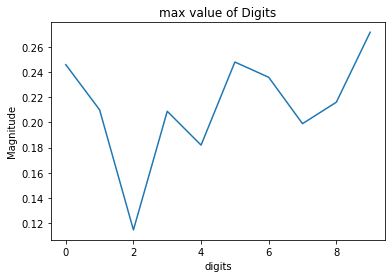

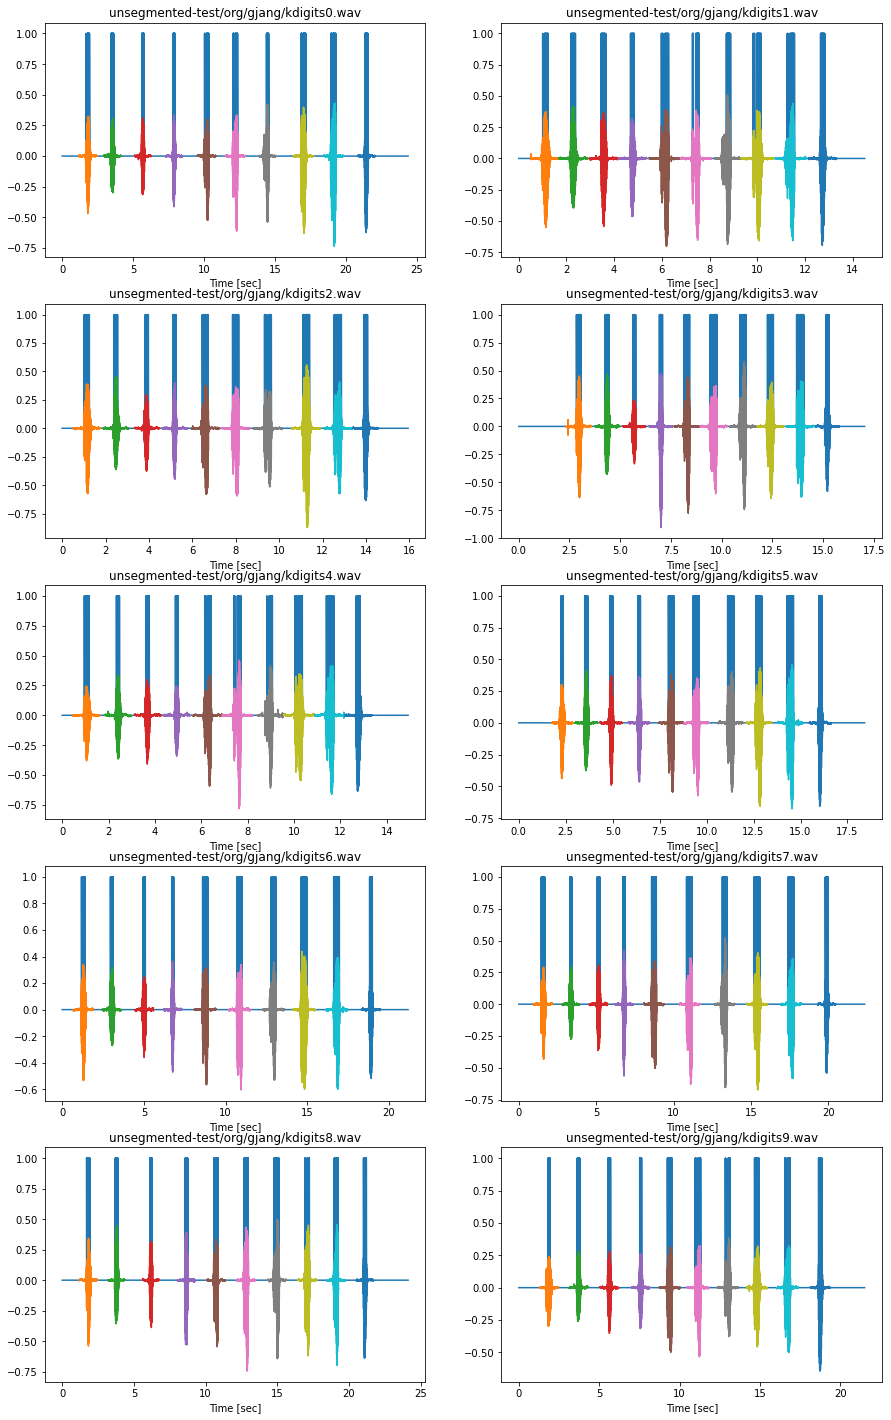

In [21]:
# unsegmented Data에서 사용할 EPD threshold를 
# 전체 validation 데이터의 최대값의 평균으로 찾겠다. -> EPD 의 threshold로 사용
######################################################################
# EPD_Thresholding
######################################################################

num_digits=10 # 전체 digit의 수

Magnitude_digits=np.zeros(num_digits) # 각 샘플의 digit별 최대값의 평균

for data_idx in range(len(Data_val)):# Data[label]=Data[label]+Data

    label_idx=Data_val[data_idx][1]
    Magnitude_digits[label_idx]=Magnitude_digits[label_idx]+(max_val[data_idx])

Magnitude_digits=Magnitude_digits/len(Data_val)*num_digits


def bin_median(x,order): # sample-wise median filtering
    med_kernel=np.ones(order)/order
    filtered=np.convolve(x,med_kernel,"same")
    
    return (filtered>0.5)

def get_border(x,near_th, margin): # EPD로 Event의 시작, 끝을 판별하는 함수
    
    EPDed_frame=x.nonzero()[0] # EPD 에서 1인 위치들을
    Event_start_bin=[]
    Event_end_bin=[]
    max_iter=len(EPDed_frame)
    T_th=np.mean(x)
    idx=0
    while(idx <max_iter):
        
        # 이전에 추정한 event 시작점에서 near_th뒤의 지점이라면, 다른 event로 취급
        es_cand=EPDed_frame[idx]
        es_mag=min(es_cand+Nf,len(x)-1)
        if len(Event_start_bin)==0 or (abs(es_cand-Event_start_bin[-1])>near_th and np.mean(x[es_cand:es_mag])>T_th):
            Event_start_bin.append(EPDed_frame[idx]-margin) # margin으로 파열음 앞 부분을 포함
        
        # 이전에 추정한 event 끝에서 near_th전의 지점이라면, 다른 event로 취급
        ee_cand=EPDed_frame[max_iter-idx-1]
        ee_mag=max(ee_cand-Nf,0)
        if len(Event_end_bin)==0 or (abs(ee_cand-Event_end_bin[-1])>near_th and np.mean(x[ee_mag:ee_cand])>T_th):
            Event_end_bin.append(EPDed_frame[max_iter-idx-1]+margin) # margin으로 파열음 뒷 부분을 포함
    
        idx=idx+1
    
    if len(Event_start_bin) != len(Event_end_bin): # Event의 시작점과 끝점의 갯수가 다르다면
        print("Mismatching in Event end and Start") # 오류 메시지를 남김
        
    for idx in range(len(Event_start_bin)):
        if Event_start_bin[idx]<0:
            Event_start_bin[idx]=0

    Ee_tmp=[]
    for idx in range(len(Event_end_bin)):
        Ee_tmp.append(Event_end_bin[len(Event_end_bin)-idx-1])
        if Ee_tmp[idx]>len(x)-1: # 얘는 뒤에서부터 이벤트를 찾았으니, 다시 뒤집어줘야 한다.
            Ee_tmp[idx]=len(x)-1
    Event_end_bin=Ee_tmp
            
    print("# of Event Start Point : {}".format(len(Event_start_bin)))    
    print("# of Event End Point : {}".format(len(Event_end_bin)))
    
    return Event_start_bin,Event_end_bin

plt.figure()
plt.plot(np.arange(num_digits),Magnitude_digits) 
plt.title("max value of Digits")
plt.xlabel("digits")
plt.ylabel("Magnitude")

######################################################################
# 아래의 그림을 통해 깔끔하게 10개의 digit으로 나눠지는 것을 알 수 있다.
# 분리된 digit들을 각각의 파일로 저장했다. 
# unsegmented-test/org/gjang/kdigits0.wav -> unsegmented-test/org/gjang_sep/kdigits0-{digits}.wav
######################################################################


save_flag=False
import os
save_folder='unsegmented-test/org/gjang_sep'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

EPD_th=np.mean(Magnitude_digits)
print("EPD Threshold : {}".format(EPD_th))

plot_idx=1
plt.figure(figsize=[15,25])

Data_sep=[] # 분리 후에 파일경로와 label을 저장할 공간
Data_sep_n=[] # 분리 후에 파일경로와 label을 저장할 공간

Event_time_line=[]

for data in Data_unseg_test:
    signal, Fs = librosa.load(data, sr=Fs, mono=True)
    time_tmp=np.arange(len(signal))/Fs
    EPD=(np.abs(signal)> EPD_th)
#     EPD=bin_median(EPD,int(Ns*0.1))
    s,e=get_border(EPD,int(Fs),int(Fs*0.5))
    Event_time_line.append((s,e))
    plt.subplot(5,2,plot_idx)
    plt.plot(time_tmp,EPD)
    for idx in range(10):
        plt.plot(np.arange(s[idx],e[idx])/Fs, signal[s[idx]:e[idx]])
        new_file_name=data.replace("gjang","gjang_sep").replace(".wav","-{}.wav".format((idx+1)%10))
        if save_flag:
            wav.writewav(new_file_name, Fs, signal[s[idx]:e[idx]], maxval=1.0)
        Data_sep.append((new_file_name,(idx+1)%10)) # (file path, label)
    plt.xlabel("Time [sec]")
            
    plt.title(data)
    plot_idx=plot_idx+1
    
SNRs=[-10,0,10]
noise_kind=['nbn','wbn']
folder_list=[]
for idx in SNRs:
    for jdx in noise_kind:
        folder_list.append("{}SNR{}".format(jdx,idx))
    
for d_idx in range(len(Data_unseg_test)):
    data=Data_unseg_test[d_idx]
    ev_time=Event_time_line[d_idx]
    for fl in folder_list:
        if not os.path.exists(save_folder.replace("org",fl)):
            os.mkdir(save_folder.replace("org",fl))
        
        Data_path=data.replace("org",fl)
#         print(Data_path)
        x,sr=librosa.load(Data_path,sr=Fs, mono=True)
        for idx in range(len(ev_time[0])):
#             plt.plot(np.arange(ev_time[0][idx],ev_time[1][idx])/Fs, x[ev_time[0][idx]:ev_time[1][idx]])
            new_file_name=Data_path.replace("gjang","gjang_sep").replace(".wav","-{}.wav".format((idx+1)%10))
            if save_flag:
                wav.writewav(new_file_name, Fs, x[ev_time[0][idx]:ev_time[1][idx]], maxval=1.0)
            Data_sep_n.append((new_file_name,(idx+1)%10)) # (file path, label)

In [22]:
############################################################
# EPD로 digit단위로 분리한 파일들에 학습했던 HMM을 적용한다. (org 데이터 사용)
###########################################################

validation_digits_modified(speechmodels, Data_sep, 'kdigits', num_trials=10)


Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validation] number of labels and features = 100, 100
Loading data completed
Prediction started

Prediction for Testing DataSet:

accuracy =29.0


Confusion Matrix (row : True, column : Predicted)
label:0 	[0. 0. 0. 0. 0. 3. 7. 0. 0. 0.] 		 accuracy : 0 %
label:1 	[ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.] 		 accuracy : 0 %
label:2 	[0. 0. 2. 1. 0. 5. 2. 0. 0. 0.] 		 accuracy : 20 %
label:3 	[0. 0. 0. 7. 0. 2. 1. 0. 0. 0.] 		 accuracy : 70 %
label:4 	[0. 0. 0. 9. 0. 1. 0. 0. 0. 0.] 		 accuracy : 0 %
label:5 	[0. 0. 0. 0. 0. 9. 1. 0. 0. 0.] 		 accuracy : 90 %
label:6 	[ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.] 		 accuracy : 0 %
label:7 	[0. 0. 0. 0. 0. 0. 3. 7. 0. 0.] 		 accuracy : 70 %
label:8 	[0. 0. 0. 0. 0. 5. 5. 0. 0. 0.] 		 accuracy : 0 %
label:9 	[0. 0. 0. 0. 0. 6. 0. 0. 0. 4.] 		 accuracy : 40 %




In [23]:
############################################################
# EPD로 digit단위로 분리한 파일들에 학습했던 HMM을 적용한다. (noisy 데이터 사용)
###########################################################
Data_sep_n.sort()
folder_list.sort()
for idx in range(len(Data_sep_n)//100):
    print("Now, Using Test Data in {}".format(folder_list[idx]))
    print("ex) {}\n".format(Data_sep_n[idx*100]))
    validation_digits_modified(speechmodels, Data_sep_n[idx*100:(idx+1)*100], 'kdigits', num_trials=10)

Now, Using Test Data in nbnSNR-10
ex) ('unsegmented-test/nbnSNR-10/gjang_sep/kdigits0-0.wav', 0)

Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validation] number of labels and features = 100, 100
Loading data completed
Prediction started

Prediction for Testing DataSet:

accuracy =14.0


Confusion Matrix (row : True, column : Predicted)
label:0 	[0. 0. 0. 7. 0. 1. 2. 0. 0. 0.] 		 accuracy : 0 %
label:1 	[0. 0. 0. 1. 0. 9. 0. 0. 0. 0.] 		 accuracy : 0 %
label:2 	[ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.] 		 accuracy : 0 %
label:3 	[ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.] 		 accuracy : 100 %
label:4 	[ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.] 		 accuracy : 0 %
label:5 	[0. 0. 0. 7. 0. 3. 0. 0. 0. 0.] 		 accuracy : 30 %
label:6 	[0. 0. 0. 5. 0. 4. 1. 0. 0. 0.] 		 accuracy : 10 %
label:7 	[0. 0. 0. 6. 0. 3. 1. 0. 0. 0.] 		 accuracy : 0 %
label:8 	[0. 0. 0. 6. 0. 4. 0. 0. 0. 0.] 		 accuracy : 0 %
label:9 	[0. 0. 0. 7. 0. 3. 0. 0. 0. 0.] 		 accuracy : 0 %


Now, Using Test Data in nbnSNR0
ex

---
### noise supression을 위한 코드
#### Lab04, Lab05에서 정의했던 함수들을 조금 수정해서 사용한다.
#### https://github.com/ln99/ssp2023/blob/main/lab04/lab04_ns_epd_InkooJeon.ipynb
#### https://github.com/ln99/ssp2023/blob/main/lab05/lab05_VAD_InkooJeon.ipynb

In [24]:
    # From lab5(previous codes)
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
from IPython.display import Audio
import soundfile

Tover=0.01
Nover=int(Fs*Tover) # overlap될 길이 (trapezoidal의 사용을 위해 정의됨)
upslope=np.linspace(0,1,Nover+2)[1:-1]

def getFIRFFT(H,order, flag_window=1, flag_display=0):
        
        NFFT=len(H)*2-1
        # real 부분을 뒤집어서 pi~ 2pi부분에 넣는다.
        mirrored=np.concatenate([H,np.flip(np.conjugate(H[0:-1]),axis=0)],axis=0)
        mirrored=mirrored+(0j)
        
        # 중앙을 기준으로 좌우 대칭인 것을 ifft한다.
        iffted=np.fft.ifft(mirrored, axis=0)
        iffted=np.concatenate([iffted[len(H):], iffted[0:len(H)]])
    
        if flag_display==1: # 디버깅용 플롯
            plt.figure()
            plt.plot(np.arange(len(mirrored))*np.pi*2/len(mirrored),mirrored)
            plt.title("Mirrored time-domain signal")
    
            plt.figure()
            plt.plot(np.arange(len(iffted)),np.real(iffted))
            plt.title("iffted signal")
            
        # 원하는 order에 해당하는 만큼만 잘라낸다.
        h=iffted[len(H)-order//2:len(H)+order//2 ]
        h=h.real
        
        if flag_window ==1: # 필요하다면 hamming window를 적용한다.
            window=signal.windows.hamming(len(h))
            h=h*window    
        return h
    
def Spectrogram(x,Ns,Nf,flag_hamm):
        # x : 음성신호
        # Ns: shift number of samples
        # Nf: frame number of samples
        # flag_hmm: switch for hamming window 1/0 (ON/OFF)
        T = len(x)   # number of samples
        #num_frames = T//Nf# 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
        num_frames = (T-Nf)//Ns + 1 
        hNo = Nf//2+1
    
        X = np.zeros((hNo,num_frames),dtype='complex')
        
        if flag_hamm >0: # window setting
            win = librosa.filters.get_window('hamming', Nf, fftbins=True)
        else:
            win = np.ones(Nf)
            
        for i in range(num_frames):
            y = x[(i*Ns):(i*Ns+Nf)]
    
            y=np.fft.fft(y*win) 
            X[:,i]= y[:hNo]
    
        return X
    
def filtering(h, x, prevx,out_len):# 필터링 후 원하는 길이만큼 출력해주는 함수
        # h : 시간차원 필터
        # x : 시간차원 신호
        # prevx : 버퍼 초기화
        # out_len : 원하는 출력 길이
        Lx=len(x)
        x_i=np.concatenate([prevx,x])
        y=np.convolve(x_i,h,"same")
        
        prevx=x_i[-len(prevx):]
        
        return y[-out_len:], prevx
    
def get_Wiener_filter(E_x,Ns,Nf,order,E_n): # wiener filter를 구해주는 함수
        # x : 시간차원 신호
        # Ns: shift할 길이
        # Nf: 프레임의 크기
        # order: wiener filter의 크기
        # E_n : 추정된 noise의 주파수 특성
        H=(E_x-E_n)/E_x
        H[H < 0.000001]=0.000001 # clipping
        h=getFIRFFT(H,order,0) # time-domain filter
        
        return h
def trapezoidal_mixing(f_idx,Nover,y,y_tmp,upslope): # trapezoidal mixing을 해주는 함수
        # f_idx : 현재 프레임 번호
        # Nf : 프레임의 길이
        # Nover : overlap될 길이
        # y : 결과를 저장할 배열
        # y_tmp : 입력된 데이터
        # upslope : mixing할 가중치 배열
        if (f_idx-1)*Ns-Nover>=0: # trapezoidal window의 적용
            y[(f_idx-1)*Ns-Nover:(f_idx-1)*Ns]=y[(f_idx-1)*Ns-Nover:(f_idx-1)*Ns]+upslope*y_tmp[:Nover]
            y[(f_idx-1)*Ns:(f_idx)*Ns]=y_tmp[Nover:]
            y[(f_idx)*Ns-Nover:(f_idx)*Ns]=y[(f_idx)*Ns-Nover:(f_idx)*Ns]*np.flip(upslope)
        else:
            y[(f_idx-1)*Ns:(f_idx)*Ns]=y_tmp[Nover:]
            y[(f_idx)*Ns-Nover:(f_idx)*Ns]=y[(f_idx)*Ns-Nover:(f_idx)*Ns]*np.flip(upslope)        
        return y
def median_filtering(x,L_filter,prevx): # median을 계산하는 필터
        # x : 시간차원의 신호
        # L_filter : median필터의 길이
        # prevx : 필터링 버퍼
    
        x_i= np.concatenate([prevx,x])
        N_frame=int(len(x_i)/L_filter)
        y=np.zeros(len(x))
        for idx in range(len(x)-L_filter):
            y[idx]=np.median(x_i[(idx):idx+L_filter])

        prevx=x_i[-len(prevx):]
        return y,prevx
    
def gaussian(x,mu,std2):
        return np.exp(-(x-mu)**2/(2*std2))/np.sqrt(2*np.pi*std2)
    
def rayleigh(x,sig2): # rayleigh distribution
        # x : 입력 데이터
        # sig2 : 파라미터 sig의 제곱    
        return np.exp(np.sum(np.log(x),axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x**2)/(2*sig2),axis=0))

def EM_Rayleigh(y_k,sig_x,sig_n,P_voice): # 다변수 rayleigh distribution의 EM알고리즘
        # y_k : 입력 데이터
        # sig_x : 음성신호의 파라미터 sig의 제곱    
        # sig_n : 노이즈의 파라미터 sig의 제곱 
        # P_voice : 음성이 있을 확률
        prob= lambda x,sig2 : np.exp(np.sum(np.log(x),axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x**2)/(2*sig2),axis=0))
        gamma=lambda fx,fy,P_voice : 1/(1+(1-P_voice)*fy/(P_voice*fx))
        mean_y_k=np.mean(y_k,axis=0)
        mu=np.mean(y_k)
        for iter in range(10):
            Px=prob(y_k,sig_x)# fx(y)
            Pn=prob(y_k,sig_n)# fn(y)
            P_v=gamma(Px,Pn,P_voice).reshape(1,-1)# P(voice | y)
            for idx in range(P_v.size):
                if int(np.isnan(P_v[0,idx])):
                    if mean_y_k[idx] < mu:
                        P_v[0,idx]=0
                    else:
                        P_v[0,idx]=1        
            P_voice=np.mean(P_v)
            sig_x=(np.mean(P_v*(y_k**2),axis=-1)/(2*P_voice)).reshape(-1,1)
            sig_n=(np.mean((1-P_v)*(y_k**2),axis=-1)/(2-2*P_voice)).reshape(-1,1)

        return P_v, sig_x, sig_n, P_voice


def EM_Rayleigh_ext(x,P_voice=None,sig_x2=None,sig_n2=None):
        Y=Spectrogram(x,Ns,Nf,1)
        y_k=np.abs(Y)
        # y_k[y_k<1e-5]=1e-5
        if P_voice ==None:
            P_voice=0.5
        
        mean_y_k=np.mean(y_k,axis=0)
        mu=np.mean(y_k)
        # 파라미터 sigma의 추정
        if sig_n2 == None:
            sig_n2=np.mean(y_k[:,mean_y_k<mu]**2,axis=-1)/2
        if sig_x2 == None:
            sig_x2=np.mean(y_k[:,mean_y_k>=mu]**2,axis=-1)/2

        sig_x2=sig_x2.reshape(-1,1)
        sig_n2=sig_n2.reshape(-1,1)
        P_v,sig_x,sig_n,P_voice=EM_Rayleigh(y_k,sig_x2,sig_n2,P_voice) # EM 알고리즘
        return sig_x,sig_n,P_voice
        
def Soft_Decision(P_voice,P_n,P_x):
        denom=(1-P_voice)*P_n+P_voice*P_x
        Result=(1-P_voice)*P_n/denom
        if np.isnan(Result) and (1-P_voice)*P_n> 0: # denom -> 0 이라면, Result -> inf 니까
            Result=1         # 최대값에 대한 제한이 필요하다.
        elif np.isnan(Result) and (1-P_voice)*P_n==0:
            Result=0
        return Result


200


Text(0, 0.5, 'Magnitude')

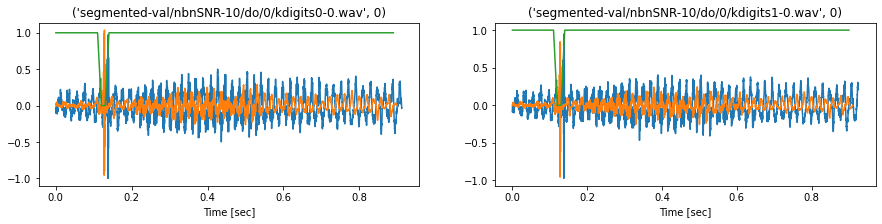

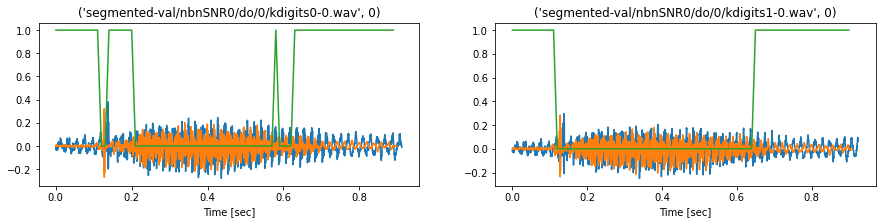

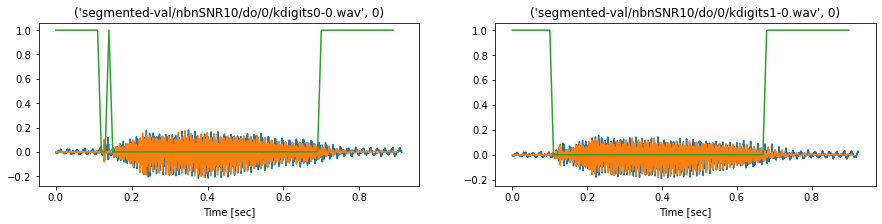

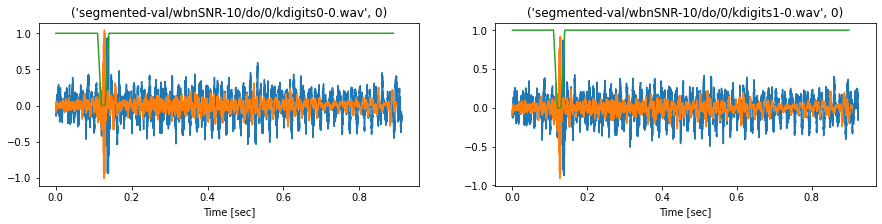

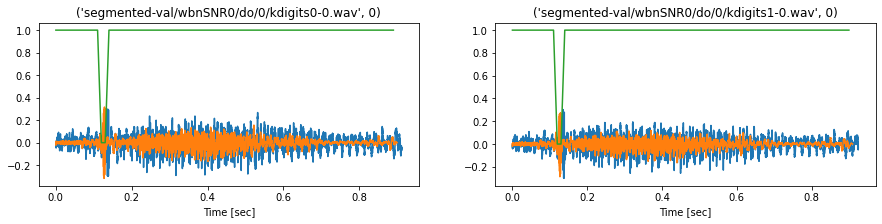

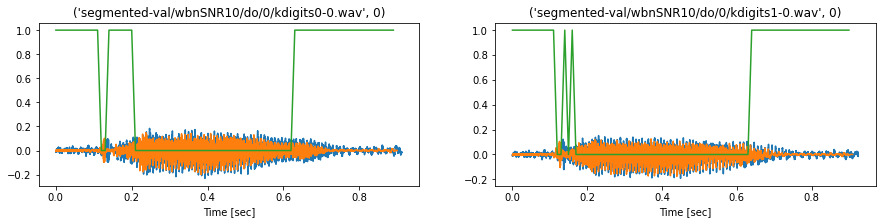

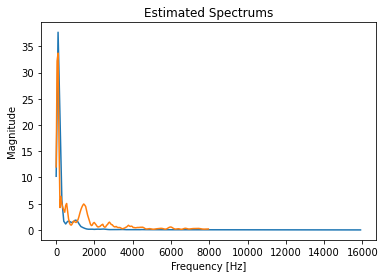

In [25]:
# EM 알고리즘으로 noisy한 데이터에서 noise spectrum을 추정하고, Validation을 하자

order=30
SNRs=[-10,0,10]
noise_kind=['nbn','wbn']
folder_list=[]

for jdx in noise_kind:
    for idx in SNRs:
        folder_list.append("{}SNR{}".format(jdx,idx))


print(len(Data_val))

N_fold=len(folder_list)

N_sample=N_fold*len(Data_val)

S_hat=None
N_hat=None
for f_idx in range(len(folder_list)):
    fl=folder_list[f_idx]
    plt.figure(figsize=[15,3])
    plot_idx=0
#     if f_idx == N_nbn:
#         N_hat_nbn=N_hat/N_sample
    for data in Data_val:
        x, Fs = librosa.load(data[0].replace("org",fl), sr=Fs, mono=True)
        time_tmp=np.arange(len(x))/Fs
        sig_x2,sig_n2,P_voice=EM_Rayleigh_ext(x,P_voice=None,sig_x2=None,sig_n2=None)
        
        mem_xsoft=np.zeros(order-1+Nover)
        y_i=np.abs(Spectrogram(x,Ns,Nf,1))
        max_iter=y_i.shape[-1]
        Decision=np.zeros(max_iter)
        y_soft=np.zeros(max_iter*Ns)
        for idx in range(max_iter):
            x_i=x[idx*Ns:idx*Ns+Nf]
            y_k=y_i[:,idx].reshape(-1,1)
            Decision[idx]=Soft_Decision(P_voice,
                                        rayleigh(y_k,sig_n2),
                                        rayleigh(y_k,sig_x2)
                                       )
            h_soft=get_Wiener_filter((y_k.reshape(-1))**2,Ns,Nf,order,(sig_n2).reshape(-1))
            y_tmp,mem_xsoft = filtering(h_soft,
                                x_i,
                                mem_xsoft,
                                Nover+Ns
                               )#  Wiener filter의 적용
            y_soft=trapezoidal_mixing(idx+1,Nover,y_soft,y_tmp,upslope)
        if S_hat is None:
            S_hat=sig_x2.reshape(-1)
        else:
            S_hat=S_hat+sig_x2.reshape(-1)

        if N_hat is None:
            N_hat= sig_n2.reshape(-1)
        else:
            N_hat= N_hat + sig_n2.reshape(-1)

        if plot_idx<2:
            plt.subplot(1,2,plot_idx+1)
            plt.plot(time_tmp,x)
            plt.xlabel("Time [sec]")
            plt.plot(np.arange(len(y_soft))/Fs,y_soft)
            plt.plot(np.arange(len(Decision))*Ns/Fs,Decision)
            plt.title((data[0].replace("org",fl),data[1]))
        plot_idx=plot_idx+1
        

N_hat=N_hat/(N_sample)
S_hat=S_hat/(N_sample)

plt.figure()
# plt.plot(np.arange(len(N_hat_nbn))*Fs/(2*len(N_hat_nbn)),N_hat_nbn)
plt.plot(np.arange(len(N_hat))*Fs/(len(N_hat)),N_hat)
plt.plot(np.arange(len(S_hat))*Fs/(2*len(S_hat)),S_hat)
plt.title("Estimated Spectrums")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")

In [26]:
print(Data_unseg_test_n[:20])

['unsegmented-test/nbnSNR-10/gjang/kdigits0.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits1.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits2.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits3.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits4.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits5.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits6.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits7.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits8.wav', 'unsegmented-test/nbnSNR-10/gjang/kdigits9.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits0.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits1.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits2.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits3.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits4.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits5.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits6.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits7.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits8.wav', 'unsegmented-test/nbnSNR0/gjang/kdigits9.wav']


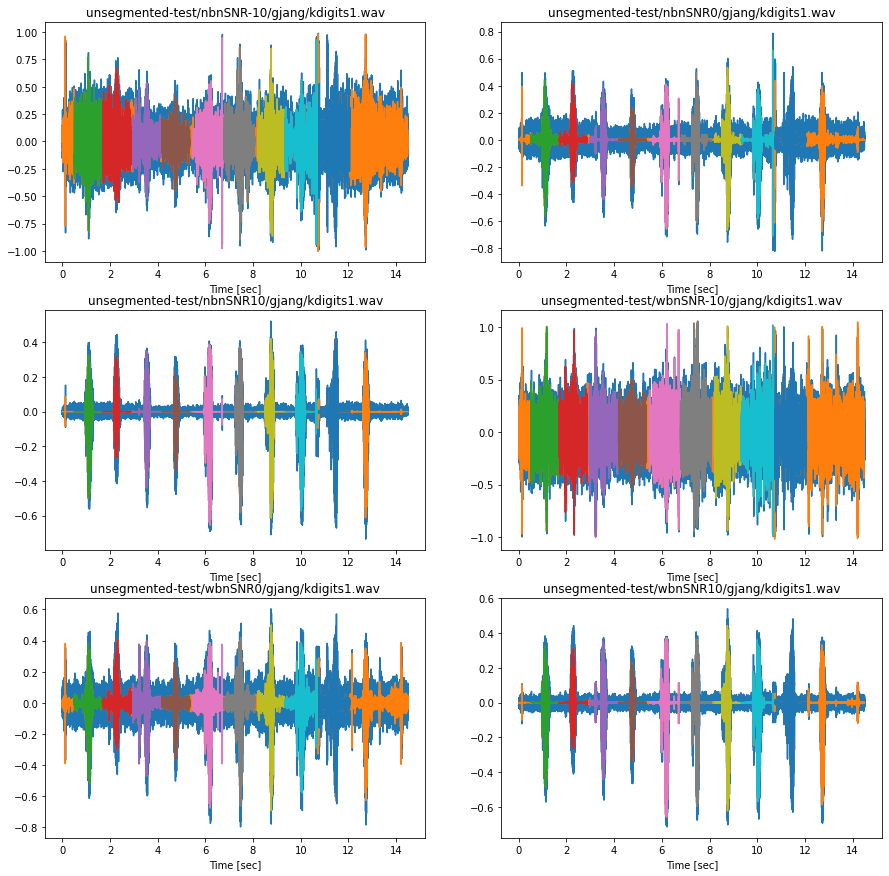

In [27]:
plot_idx=0
order=30
P_voice=0.5
Data_EPDed=[]


plt.figure(figsize=[15,15])
for d_idx in range(len(Data_unseg_test_n)):
    data=Data_unseg_test_n[d_idx]
    
    x, Fs = librosa.load(data, sr=Fs, mono=True)
    time_tmp=np.arange(len(x))/Fs
        
    X=np.abs(Spectrogram(x,Ns,Nf,1))
    max_iter=X.shape[-1]
    y_soft=np.zeros(max_iter*Ns)
    mem_xsoft=np.zeros(order-1+Nover)
    Decision=np.zeros(max_iter)
    for idx in range(max_iter):
        x_i=x[idx*Ns:idx*Ns+Nf]
        X_k=X[:,idx]
        X_k=X_k.reshape(-1,1)
        EPD_tmp=np.mean(np.abs(x_i)> EPD_th)
        Decision[idx]=Soft_Decision(0.5,
                                    rayleigh(X_k,N_hat.reshape(-1,1)),
                                    rayleigh(X_k,S_hat.reshape(-1,1))
                                    )
        X_k=X_k.reshape(-1)
        h_soft=get_Wiener_filter(X_k**2,
                                 Ns,
                                 Nf,
                                 order,
                                 N_hat.reshape(-1))
        y_tmp,mem_xsoft = filtering(h_soft,
                                    x_i,
                                    mem_xsoft,
                                    Nover+Ns
                                    )#  Wiener filter의 적용
        
        y_soft=trapezoidal_mixing(idx+1,Nover,y_soft,y_tmp,upslope)
        
    
    if plot_idx%10 == 1:
        plt.subplot(3,2,plot_idx//10+1)
        EPD=(np.abs(x)> EPD_th)
        plt.plot(time_tmp,x)
        plt.plot(np.arange(len(y_soft))/Fs,y_soft)
#         plt.plot(np.arange(len(Decision))/Fs*Ns,Decision)
        plt.title(data)
        plt.xlabel("Time [sec]")
#         Audio(data=y_soft,rate=Fs)
#         print(len(get_border(EPD)))
    
    ev_time=Event_time_line[d_idx%10]
    if plot_idx%10 ==1:
        for idx in range(len(ev_time[0])):
            plt.plot(np.arange(ev_time[0][idx],ev_time[1][idx])/Fs,y_soft[ev_time[0][idx]:ev_time[1][idx]])
        
    for idx in range(len(ev_time[0])):
        new_file_name=data.replace("gjang","gjang_epded").replace(".wav","-{}.wav".format((idx+1)%10))
        if save_flag:
            wav.writewav(new_file_name, Fs, y_soft[ev_time[0][idx]:ev_time[1][idx]], maxval=1.0)
        Data_EPDed.append((new_file_name,(idx+1)%10)) # (file path, label)
    plot_idx=plot_idx+1


# save_folder=save_folder.replace("_sep","_epded")
# for d_idx in range(len(Data_unseg_test)):
#     data=Data_unseg_test[d_idx]
#     ev_time=Event_time_line[d_idx]
#     for fl in folder_list:
#         if not os.path.exists(save_folder.replace("org",fl)):
#             os.mkdir(save_folder.replace("org",fl))
        
#         Data_path=data.replace("org",fl)
# #         print(Data_path)
#         x,sr=librosa.load(Data_path,sr=Fs, mono=True)


In [28]:
folder_list.sort()
Data_EPDed.sort()
print(Data_EPDed[:20])

[('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-0.wav', 0), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-1.wav', 1), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-2.wav', 2), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-3.wav', 3), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-4.wav', 4), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-5.wav', 5), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-6.wav', 6), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-7.wav', 7), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-8.wav', 8), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-9.wav', 9), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-0.wav', 0), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-1.wav', 1), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-2.wav', 2), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-3.wav', 3), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-4.wav', 4), ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits1-5.wav', 5), ('unseg

In [29]:
for idx in range(len(Data_EPDed)//100):
    print("Now, Using Test Data in {}".format(folder_list[idx]))
    print("ex) {}\n".format(Data_EPDed[idx*100]))
    validation_digits_modified(speechmodels, Data_EPDed[idx*100:(idx+1)*100], 'kdigits', num_trials=10)

Now, Using Test Data in nbnSNR-10
ex) ('unsegmented-test/nbnSNR-10/gjang_epded/kdigits0-0.wav', 0)

Words spoken: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[validation] number of labels and features = 100, 100
Loading data completed
Prediction started

Prediction for Testing DataSet:

accuracy =9.0


Confusion Matrix (row : True, column : Predicted)
label:0 	[0. 0. 0. 3. 0. 0. 6. 0. 1. 0.] 		 accuracy : 0 %
label:1 	[0. 0. 0. 1. 0. 0. 6. 0. 3. 0.] 		 accuracy : 0 %
label:2 	[0. 0. 0. 1. 0. 0. 9. 0. 0. 0.] 		 accuracy : 0 %
label:3 	[ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.] 		 accuracy : 0 %
label:4 	[ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.] 		 accuracy : 0 %
label:5 	[0. 0. 0. 0. 0. 1. 6. 0. 3. 0.] 		 accuracy : 10 %
label:6 	[0. 0. 0. 0. 0. 0. 7. 0. 3. 0.] 		 accuracy : 70 %
label:7 	[0. 0. 0. 2. 0. 0. 6. 0. 2. 0.] 		 accuracy : 0 %
label:8 	[0. 0. 0. 1. 0. 0. 8. 0. 1. 0.] 		 accuracy : 10 %
label:9 	[0. 0. 0. 1. 0. 0. 7. 0. 2. 0.] 		 accuracy : 0 %


Now, Using Test Data in nbnSNR0
ex) ('unsegm

## End of Project 1